In [25]:
import pandas as pd
import numpy as np
import os
import csv
import pylab as pl
from __future__ import print_function
import matplotlib.pyplot as plt
import scipy.stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! curl 'https://s3.amazonaws.com/tripdata/JC-201801-citibike-tripdata.csv.zip' > newcitibike.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  327k  100  327k    0     0  1827k      0 --:--:-- --:--:-- --:--:-- 1821k


In [3]:
# Moving .csv file into environmental variable.  For reproducibility purposes

!mv newcitibike.zip $PUIDATA

In [4]:
# ! unzip $PUIDATA/newcitibike.zip -d $PUIDATA

Archive:  /nfshome/jl9489/PUIdata/newcitibike.zip
replace /nfshome/jl9489/PUIdata/JC-201801-citibike-tripdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Data Wrangling

In [5]:
# Assign a local variable in notebook to hold data frame.  Then show first 7 rows.

citibike_data = pd.read_csv(os.getenv('PUIDATA')+'/JC-201801-citibike-tripdata.csv')

citibike_data.head(7)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,932,2018-01-01 02:06:17.5410,2018-01-01 02:21:50.0270,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31929,Subscriber,1992,1
1,550,2018-01-01 12:06:18.0390,2018-01-01 12:15:28.4430,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31845,Subscriber,1969,2
2,510,2018-01-01 12:06:56.9780,2018-01-01 12:15:27.8100,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,31708,Subscriber,1946,1
3,354,2018-01-01 14:53:10.1860,2018-01-01 14:59:05.0960,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,31697,Subscriber,1994,1
4,250,2018-01-01 17:34:30.1920,2018-01-01 17:38:40.9840,3183,Exchange Place,40.716247,-74.033459,3639,Harborside,40.719252,-74.034234,31861,Subscriber,1991,1
5,613,2018-01-01 22:05:05.8740,2018-01-01 22:15:19.4190,3183,Exchange Place,40.716247,-74.033459,3203,Hamilton Park,40.727596,-74.044247,31859,Subscriber,1982,1
6,290,2018-01-02 12:13:51.7940,2018-01-02 12:18:42.1070,3183,Exchange Place,40.716247,-74.033459,3267,Morris Canal,40.712419,-74.038526,31694,Subscriber,1958,1


## Null Hypothesis Test

Idea: Citibike users born after 1980 have longer bike trips than users born before 1980.  I'm looking to test if there is any correlation between age and activity level, using Citibike data as proxy.  Any statistically meaningful difference could serve as evidence for more study.

Null Hypothesis: During the month of Jan 2018, the avg trip duration for users born after 1980 was equal to the
                    trip duration for users born before 1980

                 H0: P0 = P1


Alternative Hypothesis: During the month of Jan 2018, the avg trip duration for users born after 1980 was not equal to
                          the trip duration for users born before 1980

                Ha: P0 != P1
                
alpha: 0.05

In [6]:
# Cleaning the data
# First, remove ages that are not representative. (In the dataset, anyone born before 1931)

print(len(citibike_data))

citibike_data = citibike_data[citibike_data['birth year'] >= 1931]

print(len(citibike_data))

12677
12666


In [7]:
# Next, isolate only columns needed for analysis


citibike_data.drop(['start station id','start station name','start station latitude','start station longitude',
                    'end station id','end station name','end station latitude','end station longitude',
                   'bikeid','usertype','gender'],axis=1, inplace=True)

citibike_data.head(7)

,tripduration,starttime,stoptime,birth year
0,932,2018-01-01 02:06:17.5410,2018-01-01 02:21:50.0270,1992
1,550,2018-01-01 12:06:18.0390,2018-01-01 12:15:28.4430,1969
2,510,2018-01-01 12:06:56.9780,2018-01-01 12:15:27.8100,1946
3,354,2018-01-01 14:53:10.1860,2018-01-01 14:59:05.0960,1994
4,250,2018-01-01 17:34:30.1920,2018-01-01 17:38:40.9840,1991
5,613,2018-01-01 22:05:05.8740,2018-01-01 22:15:19.4190,1982
6,290,2018-01-02 12:13:51.7940,2018-01-02 12:18:42.1070,1958


In [8]:
# Assign values to each age group, in order to plot.  Similar to the gender demarcation.

age_group = []

for i in citibike_data['birth year']:
    if i <= 1980:
        age_group.append('before_1980')
    else:
        age_group.append('after_1980')
    
    
citibike_data['before_after_1980'] = age_group    

citibike_data.head(7)

,tripduration,starttime,stoptime,birth year,before_after_1980
0,932,2018-01-01 02:06:17.5410,2018-01-01 02:21:50.0270,1992,after_1980
1,550,2018-01-01 12:06:18.0390,2018-01-01 12:15:28.4430,1969,before_1980
2,510,2018-01-01 12:06:56.9780,2018-01-01 12:15:27.8100,1946,before_1980
3,354,2018-01-01 14:53:10.1860,2018-01-01 14:59:05.0960,1994,after_1980
4,250,2018-01-01 17:34:30.1920,2018-01-01 17:38:40.9840,1991,after_1980
5,613,2018-01-01 22:05:05.8740,2018-01-01 22:15:19.4190,1982,after_1980
6,290,2018-01-02 12:13:51.7940,2018-01-02 12:18:42.1070,1958,before_1980


In [9]:
# Find the average of each age group

before_age = citibike_data.loc[(citibike_data["birth year"] < 1980)]
after_age = citibike_data.loc[(citibike_data["birth year"] >= 1980)]



print("The mean trip time (in seconds) for users born before 1980 is: %i seconds" %(before_age['tripduration'].mean()))
print("The mean trip time (in seconds) for users born in 1980 and after is: %i seconds" %(after_age['tripduration'].mean()))

The mean trip time (in seconds) for users born before 1980 is: 540 seconds
The mean trip time (in seconds) for users born in 1980 and after is: 528 seconds


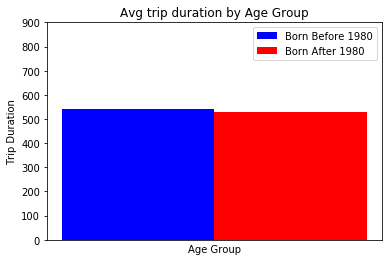

In [21]:
# Graph avg trip duration for both age groups, born before and after 1980


n_bars = 1
width = 0.01

index = np.arange(n_bars)


p1 = plt.bar(index, before_age['tripduration'].mean(), width, color ='b')
p2 = plt.bar(index + width, after_age['tripduration'].mean(), width, color = 'r')

plt.ylabel('Trip Duration')
plt.xlabel('Age Group')
plt.title('Avg trip duration by Age Group')
plt.yticks(np.arange(0, 1000, 100))

#Remove x-tick marks
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.legend((p1[0], p2[0]), ('Born Before 1980', 'Born After 1980'))

plt.show()

Figure 1: The above bar graph compares the mean trip duration for Citi Bike users born before 1980 (540 seconds) and users born after 1980 (528 seconds).

## Statistical Analysis

The following data does not follow a Gaussian distribution.  However, it is a large sample, and is randomly generated, so the distribution of means should approach the Gaussian. As such, I will use the t-test to compare means and identify any statistically significant results.

In [32]:
scipy.stats.ttest_ind(before_age['tripduration'],
                      after_age['tripduration'])

Ttest_indResult(statistic=0.075324002966132425, pvalue=0.93995811389486161)